In [27]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional, Union, Literal
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser, create_sync_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.chat_history import InMemoryChatMessageHistory
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field, model_validator, field_validator
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv
import operator
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool
from playwright.async_api import async_playwright
from langchain_community.agent_toolkits import FileManagementToolkit
from datetime import datetime, date, timedelta
from langchain_core.tools import tool
import nest_asyncio
load_dotenv(override=True)

True

# Tools

In [28]:
# google search tool
serper = GoogleSerperAPIWrapper()
web_search_tool =Tool(
    name="web_search_tool",
    func=serper.run,
    description="Use this tool when you want to get the results of an online web search and make recommendations based on the results."
)

In [29]:
#playwright tools (browser use)
async def playwright_tools():
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False)
    toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=browser)
    return toolkit.get_tools(), browser, playwright


browser_tools, browser, playwright = await playwright_tools()

In [30]:
browser_tools

[ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 NavigateBackTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 ExtractTextTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 ExtractHyperlinksTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\1997e\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=138.0.7204.23>),
 GetElementsTool(async_browser=<Brows

In [31]:
# date tool to get dates in the future
@tool
def date_tool(input: str) -> str:
    """You can suggest dates in the future"""
    system_message = f"You can suggest dates in the future Assume today is {datetime.now().strftime("%Y-%m-%d")}. Recommend dates strictly after today."
    llm = ChatOpenAI(model="gpt-4o-mini", description=system_message)
    return llm.invoke(input)


In [32]:
# emailing tools
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
@tool
def subject_writer(input: str) -> str:
    """You can write a subject for an travel planning email"""
    llm = ChatOpenAI(model="gpt-4o-mini")
    return llm.invoke(input)

@tool
def html_converter(input: str) -> str:
    """You can convert a text body to an HTML email body. You are given a text body which might have some markdown and you need to convert it to an HTML email body with simple, clear, compelling layout and design."""
    llm = ChatOpenAI(model="gpt-4o-mini")
    return llm.invoke(input)

def send_html_email(subject: str, html_body: str, recipient: str) -> Dict[str, str]:
    """You can send an email to a recipient with the given subject and HTML body."""
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("1997.e.t@gmail.com")  # Change to your verified sender
    to_email = To(recipient)  # Change to your recipient
    content = Content("text/html", html_body)
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

email_tools = [subject_writer, html_converter]

In [33]:
# test the email sending function
# send_html_email("test subject", "test html_body", "1997.e.t@gmail.com")

In [34]:
# tools to allow llm to access files
def get_file_tools():
    toolkit = FileManagementToolkit(root_dir="sandbox") # sandbox is the folder the llm can access
    return toolkit.get_tools()
file_tools = get_file_tools()

# Structured Outputs and State

In [35]:
class Location(BaseModel):
    country: str = Field(description="The country of the location")
    city: str = Field(description="The city of the location")
    address: str = Field(description="The precise address of the location")

class InitialInformation(BaseModel):
    email_address: str = Field(description="The email address of the user")
    home_location: Optional[Location] = Field(description="The user's home location.")
    trip_locations: List[Location] = Field(description="The locations of the trip")
    start_date: Optional[date] = Field(description="The start date of the trip in the format YYYY-MM-DD after today")
    end_date: Optional[date] = Field(description="The end date of the trip in the format YYYY-MM-DD after today and after the start date")
    duration: int = Field(description="The length of the trip in days")
    num_adults: int = Field(description="The number of adults in the trip")
    num_children: int = Field(description="The number of children in the trip")
    budget: Optional[int] = Field(description="The budget for the trip in USD")
    other_preferences: Optional[List[str]] = Field(description="List of user preferences that do not fit into the other fields")
    completed: bool = Field(description="Whether the user has provided all the information needed")
    
class Activity(BaseModel):
    name: str = Field(description="The name of the activity")
    description: str = Field(description="The description of the activity")
    location: Location = Field(description="The location of the activity")
    time: str = Field(description="The time of the activity in the format HH:MM")
    notes: Optional[str] = Field(description="Notes about the activity")
    activity_link: str = Field(description="the web link or url to the activity or location")

class Meal(BaseModel):
    name: Literal["breakfast", "lunch", "dinner"] = Field(description="The name of the meal")
    food_options: List[str] = Field(description="The list of food options available for the meal")
    location: Location = Field(description="The location of the meal")
    time: str = Field(description="The time of the meal in the format HH:MM")
    notes: Optional[str] = Field(description="Notes about the meal")

class FlightOption(BaseModel):
    airline: str = Field(description="the airline providing this flight")
    flight_date: date = Field(description="the date the flight leaves")
    flight_departure_time: str = Field(description="The time the flight departs from the starting airport in HH:MM")
    flight_duration: str = Field(description="The duration of the flight in the format x hours, y minutes")
    cost: int = Field(description="The cost of the flight")
    notes: str = Field(description="any notes the user should know about the flight")
    flight_link: str = Field(description="the web link or url to the flight from the airline website")

class FlightRoute(BaseModel):
    from_loc: Location = Field(description="Start airport location of the flight")
    to_loc: Location = Field(description="Destination airport location of the flight")
    flight_options: List[FlightOption] = Field("The list of flight options for this flight route")
    
class ItineraryItem(BaseModel):
    # one item represents one day of the trip
    item_date: date = Field(description="The date of the day in the format YYYY-MM-DD")
    activities: List[Activity] = Field(description="The list of activities of the day")
    meals: List[Meal] = Field(description="The list of meals of the day")
    is_flying_day: bool = Field(description="Whether there will be airplane travel on this day")

class ItineraryDetails(BaseModel):
    items: List[ItineraryItem] = Field(description="The itinerary of the trip")
    flights: List[FlightRoute] = Field(description="The list of flight routes")
    completed: bool = Field(description="Whether the itinerary is complete")

class MyEmail(BaseModel):
    html_body: str = Field(description="The HTML body of the email")
    subject: str = Field(description="The subject of the email")


In [36]:
# the state
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    initial_information: Optional[InitialInformation]
    # initial_information_ready: bool
    itinerary_details: Optional[ItineraryDetails]
    email_content: Optional[str]
    email: Optional[MyEmail]
    email_sent: bool
    

# Helper functions

In [37]:
# routers
def gather_or_plan(state: State) -> str:
    if state["email_sent"]:
        return "thanker"
    print("in gather or plan edge")
    initial_information = state["initial_information"]
    if initial_information is None:
        return "information_gatherer"
    elif initial_information.completed:
        return "itinerary_planner"
    else:
        return "information_gatherer"

In [38]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

In [39]:
def location_parser(l: Location) -> str:
    ret_string = f"""
    location country: {l.country}
    location city: {l.city}
    location address: {l.address}

    """
    return ret_string

def activity_parser(act: Activity) -> str:
    ret_string = f"""
    activity name: {act.name}
    activity description: {act.description}
    activity location: {location_parser(act.location)}
    activity time: {act.time}
    activity notes: {act.notes}
    activity link: {act.activity_link}
    
    """
    return ret_string

def activities_parser(acts: List[Activity]) -> str:
    ret_string = ""
    for act in acts:
        ret_string += activity_parser(act)
    return ret_string

def meal_parser(meal: Meal) -> str:
    ret_string = f"""
    meal name: {meal.name}
    food options: {meal.food_options}
    meal location: {location_parser(meal.location)}
    meal time: {meal.time}
    meal notes: {meal.notes}
    
    """
    return ret_string

def meals_parser(meals: List[Meal]) -> str:
    ret_string = ""
    for meal in meals:
        ret_string += meal_parser(meal)
    return ret_string

def flight_options_parser(flight_option: FlightOption) -> str:
    ret_string = f"""
    airline: {flight_option.airline}
    flight date: {flight_option.flight_date}
    flight departure time: {flight_option.flight_departure_time}
    flight duration: {flight_option.flight_duration}
    flight cost: {flight_option.cost}
    notes about the flight: {flight_option.notes}
    flight link: {flight_option.flight_link}

    """
    return ret_string
    

def flight_route_parser(flight_route: FlightRoute) -> str:
    ret_string = f"""
    Here are the flight options to travel from {flight_route.from_loc} to {flight_route.to_loc}
    """
    for f in flight_route.flight_options:
        ret_string += flight_options_parser(f)
    return ret_string

def itinerary_item_parser(item: ItineraryItem) -> str:
    ret_string = f"""
    itinerary item date: {item.item_date}
    itinerary item activities: {activities_parser(item.activities)}
    itinerary item meals: {meals_parser(item.meals)}
    
    """
    return ret_string

def itinerary_details_parser(it_details: ItineraryDetails) -> str:
    ret_string = "Itinerary:\n"
    for i in it_details.items:
        ret_string += itinerary_item_parser(i)
    for f in it_details.flights:
        ret_string += flight_route_parser(f)
    return ret_string



# Agents

In [40]:
# initialize llm
# from langgraph.prebuilt.chat_agent_executor import StructuredResponseSchema

# information gathering agent
def information_gatherer(state: State) -> State:
    print("in information gathering agent")
    # print(state)
    current_initial_information = state["initial_information"]
    if current_initial_information is None:
        current_initial_information = {
            "email_address" : "",
            "home_location": None,
            "trip_locations": [],
            "start_date": None,
            "end_date": None,
            "duration": 0,
            "num_adults": 0,
            "num_children": 0,
            "budget": None, 
            "other_preferences": [],

            "completed": False
        }
    last_response = state["messages"][-1].content
    print("last response: ", last_response)
    gathered_information = f"""gathered information:
        email_address: {current_initial_information["email_address"]}
        home_location: {current_initial_information["home_location"]}
        trip_locations: {current_initial_information["trip_locations"]}
        start_date: {current_initial_information["start_date"]}
        end_date: {current_initial_information["end_date"]}
        duration: {current_initial_information["duration"]}
        num_adults: {current_initial_information["num_adults"]}
        num_children: {current_initial_information["num_children"]}
        budget: {current_initial_information["budget"]}
        other_preferences: {current_initial_information["other_preferences"]}
        """
    chat_history = format_conversation(state["messages"])
    system_message = f"""You are an information gatherer and travel recommender for a travel agency that can use tools to complete tasks. You use friendly and engaging language to engage the user.
    Your task is the ask the user for information about their trip. 
    Here are the required pieces of information you need to gather:
    - the user's email address
    - the user's home location
    - the trip locations the user wants to visit
    - the dates when the user wants to travel. Dates must be in the future and the end date must be after the start date.
    - the duration of the trip in days (the number of days the user wants to travel). If the user provides exact start and end dates, the duration is the number of days between the two dates.
    - the number of adults who will be travelling 
    - the number of children who will be travelling
    - the budget for the trip
    - any other preferences the user has (such as what the user likes and dislikes)

    If you are unsure of what to ask, use any user preferences you have gathered to make suggestions to continue gathering information.

    If the user does not provide information do not make up information. 
    You should only ask for one piece of information at a time so you don't overwhelm the user, and always thank the user when they provide the information.

    If the user wants a suggestion or recommendation, search the web using the user's preferences to find locations and dates that match the user's preferences.
    The today's date is {datetime.now().strftime("%Y-%m-%d")}, do not suggest dates before the current date. Always suggest dates that are after today's date.

    If you want to ask the user for dates, include "When do you want to travel?" in your message.
    
    Use the following gathered information {gathered_information} and the chat history {chat_history} to guide your response to the user.

    Fill in the fields to the structured output only with the information you have gathered from the user. Do not make up information. 

    If you think you have gathered all the required information needed, neatly show the user the gathered information and ask the user to confirm if they have provided all the information.
    Only return completed = True if the user has confirmed the information.
    """

    information_gatherer_agent = create_react_agent(
        model="gpt-4o",
        tools=[web_search_tool,date_tool],
        prompt=system_message,
        response_format = InitialInformation
    )
    try:
        response = information_gatherer_agent.invoke({"messages": [{"role": "user", "content": last_response}]})
        print("response: ", response)
        update_initial_information = {
            "email_address": response["structured_response"].email_address,
            "home_location": response["structured_response"].home_location,
            "trip_locations": response["structured_response"].trip_locations,
            "start_date": response["structured_response"].start_date,
            "end_date": response["structured_response"].end_date,
            "duration": response["structured_response"].duration,
            "num_adults": response["structured_response"].num_adults,
            "num_children": response["structured_response"].num_children,
            "budget": response["structured_response"].budget,
            "other_preferences": response["structured_response"].other_preferences,
            "completed": response["structured_response"].completed
        }
        new_state = {
            "messages": response["messages"][-1].content ,
            "initial_information": update_initial_information
        }
        print("response: ", response["messages"][-1].content)
        print("structured output: ", response["structured_response"])
        return new_state
    except Exception as e:
        print("error: ", e)
        return {
            "messages": [AIMessage(content="I'm sorry, I'm having trouble gathering the information. Please try again.")],
            "initial_information": current_initial_information
        }
    

In [50]:
async def itinerary_planner(state: State) -> State:
    print("in travel planner")
    # print(state)
    user_info = state["initial_information"]

    gathered_information = f"""gathered information:
        home_location: {user_info.home_location}
        trip_locations: {user_info.trip_locations}
        start_date: {user_info.start_date}
        end_date: {user_info.end_date}
        duration: {user_info.duration}
        num_adults: {user_info.num_adults}
        num_children: {user_info.num_children}
        budget: {user_info.budget}
        other_preferences: {user_info.other_preferences}
        """
    system_message = f"""You are an expert travel planner that should use tools to plan an itinerary for the user. 
    You will be given a set of information that you should use to plan the itinerary.
    information will include home location, trip locations, start date, end date, duration in days, number of adults, number of children, budget, and other preferences.
    Your task is to create a day by day itinerary for the user. Focus on finding activities based on the user's preferences and the trip locations.
    You must include all the trip locations in the itinerary. spreading the trip locations out over the duration of the trip as evenly as possible while accounting for travel time.
    Once you visit a trip location, you should not visit it again.
    You should use the following guidelines:
    - each day should be a separate item in the itinerary, you must plan out every day of the trip. Do not reuse activities
    - addresses should be as specific as possible
    - when writing descriptions, include as much information as you can. You are trying to give as much about the activity or flight to the user as possible to help them with the itinerary
    - descriptions should be at least a few sentences long with relevant information
    - There should only be one or two activities per day, ideally one in the morning and one in the afternoon.
    - There should be 3 meals per day. Breakfast should start around 8 am, lunch should start around 1pm, and dinner should start around 6:30 pm
    - The order of events for the day should be: Breakfast, 1st activity, Lunch, 2nd activity, Dinner
    - If a day is used for flying, then flying should be the only activity, and note down if meals are provided on the flight
    - The first day should be the day of the start date and start with a flight to the first location from the home location
    - The last day should be the day of the end date and end with a flight to the home location. Do not return home until the last day.
    - when searching for flights, make sure you include at least 3 flight options per flight route.

    
    Order the itinerary items by date and time.

    Output the itinerary to the structured output.
    """

    user_message = f"""Help plan an itinerary using the following information: {gathered_information}
    Make sure the itinerary is planned in a way that is feasible and includes all the trip locations"""

    itinerary_planning_agent = create_react_agent(
        model="gpt-4o",
        tools=browser_tools,
        prompt=system_message,
        response_format = ItineraryDetails
    )
    
    response = await itinerary_planning_agent.ainvoke({"messages": [{"role": "user", "content": user_message}]})
    print("itinerary planner response: ", response)
    new_state = {
        "itinerary_details": response["structured_response"]
    }
    return new_state

    

In [51]:
# flight finding agent
# pass in when the itinerary item is_flight is true
# look up flights on the web 

In [52]:
# itinerary formatter
def itinerary_formatter(state: State) -> State:
    print("in itinerary formatter")
    user_message = itinerary_details_parser(state["itinerary_details"])

    system_message = f"""You are a text formatter that should nicely format the itinerary details into a coherent, readabletext format that is easy to understand but contains all the information from the itinerary. You will take in an itinerary as input.
    Each day should be a separate item in the itinerary. Only use the information provided.
    Order your output by date and time
    Only reply with the formatted itinerary and the flight options."""
    llm = ChatOpenAI(model="gpt-4o-mini")
    response = llm.invoke([SystemMessage(content=system_message), HumanMessage(content=user_message)])
    print("itinerary formatter response: ", response.content)
    new_state = {
        "email_content": response.content
    }
    return new_state

In [53]:
# email sender
def email_formatter(state: State) -> State:
    email_content = state["email_content"]
    print("in email sender")
    system_message = f"""You are an email crafter that should format itinerary details given to you into an email and send it to the user. Only reformat the itinerary to html, do not alter or change the content
    Your reply should only the email body in html format and the subject."""
    email_formatting_agent = create_react_agent(
        model="gpt-4o-mini",
        tools=email_tools,
        prompt=system_message,
        response_format = MyEmail
    )
    response = email_formatting_agent.invoke({"messages": [{"role": "user", "content": email_content}]})
    print("email formatter response:", response)
    new_myemail = response["structured_response"]
    # send email
    send_html_email(new_myemail.subject, new_myemail.html_body, state["initial_information"].email_address)
    last_msg = "Thanks for using my travel planning services! Please check your email for the itinerary"
    new_state = {
        "messages": [AIMessage(content=last_msg)],
        "email": new_myemail,
        "email_sent": True
    }
    return new_state

In [54]:
def thanker(state: State) -> State:
    response = "Thanks for using my travel planning services! Please check your email for the itinerary"
    
    return {
        "messages": AIMessage(content=response)
    }

# Building the Graph

In [55]:
graph_builder = StateGraph(State)
graph_builder.add_node("information_gatherer", information_gatherer)
graph_builder.add_node("itinerary_planner", itinerary_planner)
graph_builder.add_node("itinerary_formatter", itinerary_formatter)
graph_builder.add_node("email_formatter", email_formatter)
graph_builder.add_node("thanker", thanker) # we have this thanker node to make the user only use this system once. after they get an email, refresh to restart
# graph_builder.add_edge(START, "information_gatherer")
graph_builder.add_conditional_edges(START, gather_or_plan, {"itinerary_planner": "itinerary_planner", "information_gatherer": "information_gatherer", "thanker": "thanker"})

graph_builder.add_edge("information_gatherer", END)
graph_builder.add_edge("itinerary_planner", "itinerary_formatter")
graph_builder.add_edge("itinerary_formatter", "email_formatter")
graph_builder.add_edge("email_formatter", END)
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


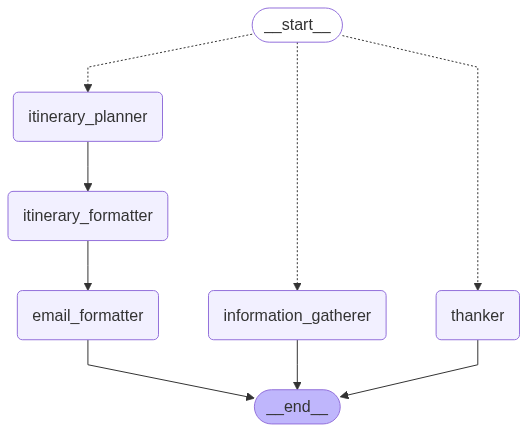

In [56]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
def make_thread_id() -> str:
    return str(uuid.uuid4())

async def process_message(message, history, state, thread):
    # first add the message to the state
    # state["messages"].append(HumanMessage(content=message))
    print("state before invoke")
    print(state)
    config = {"configurable": {"thread_id": thread}, "recursion_limit": 100}
    
    new_state = await graph.ainvoke(state, config=config) # returns the state
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": new_state["messages"][-1].content}
    # state["messages"].append(HumanMessage(content=message))
    print("state after invoke")
    # print(new_state)
    # print("return of process message")
    # print(history + [user, reply])
    final_state = new_state
    return "", history + [user, reply], new_state

async def reset():
    return "", "", make_thread_id(), State(messages = [], initial_information = None,  itinerary_details = None, email_content = None, email = None, email_sent = False)



In [58]:
state_0 = State(messages = [], initial_information = None,  itinerary_details = None, email_content = None, email = None, email_sent = False)

initial_information_test1 = InitialInformation(
    email_address="1997.e.t@gmail.com",
    home_location=Location(country='USA', city='Chicago', address='123 Main St.'), 
    trip_locations=[Location(country='Italy', city='Florence', address='Piazza della Signoria 1, Florence'), Location(country='Japan', city='Kyoto', address='Kinkaku-ji Temple, Kyoto')], 
    start_date=date(2025, 12, 1), 
    end_date=date(2025, 12, 15), 
    duration=15, 
    num_adults=1, 
    num_children=0, 
    budget=5000, 
    other_preferences=['Enjoys trying new food'], 
    completed=True)
test_state1 = State(messages = [], initial_information = initial_information_test1,  itinerary_details = None, flights=None, email_content = None, email = None, email_sent = False)

with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Travel Planning Expert")
    thread = gr.State(make_thread_id())
    state = gr.State(test_state1)

    with gr.Row():
        chatbot = gr.Chatbot(label="The agent", height=300, type="messages")
    with gr.Row():
        message = gr.Textbox(show_label=False, placeholder="Please start by letting us know where you would like to go!")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, chatbot, state, thread], [message, chatbot, state])
    go_button.click(process_message, [message, chatbot, state, thread], [message,chatbot, state])
    reset_button.click(reset, [], [message, chatbot, thread, state])

    
demo.launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


state before invoke
{'messages': [], 'initial_information': InitialInformation(email_address='1997.e.t@gmail.com', home_location=Location(country='USA', city='Chicago', address='123 Main St.'), trip_locations=[Location(country='Italy', city='Florence', address='Piazza della Signoria 1, Florence'), Location(country='Japan', city='Kyoto', address='Kinkaku-ji Temple, Kyoto')], start_date=datetime.date(2025, 12, 1), end_date=datetime.date(2025, 12, 15), duration=15, num_adults=1, num_children=0, budget=5000, other_preferences=['Enjoys trying new food'], completed=True), 'itinerary_details': None, 'flights': None, 'email_content': None, 'email': None, 'email_sent': False}
in gather or plan edge
in travel planner
itinerary planner response:  {'messages': [HumanMessage(content="Help plan an itinerary using the following information: gathered information:\n        home_location: country='USA' city='Chicago' address='123 Main St.'\n        trip_locations: [Location(country='Italy', city='Floren